# Gradient Boosting

The next classification model we will investigate is the Gradient Boosting Classifier.

## Importing the libraries

In [108]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd


# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For creating the model
from sklearn.ensemble import GradientBoostingClassifier

#For evaluating the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, balanced_accuracy_score

## Importing the splits

In [109]:
import pickle

#Loading the training and test splits from the pickle file
with open('../data/train_test_data.pickle', 'rb') as file:
    train_test_split = pickle.load(file)

X_train_raw = train_test_split['X_train_raw']
y_train_raw = train_test_split['y_train_raw']
X_test_raw = train_test_split['X_test_raw']
y_test_raw = train_test_split['y_test_raw']

In [110]:
with open('../data/train_splits.pickle', 'rb') as file:
    split_data = pickle.load(file)

In [111]:
split_data.keys()

dict_keys(['random', 'stratified', 'undersample', 'oversample'])

## Initial Model

Here, we'll create an initial classification model using the GradientBoostingClassifier function from scikit-learn and test it on our splits. We will use the default parameters but set the random seed to 0 to allow for effective and relevant comparison later on.

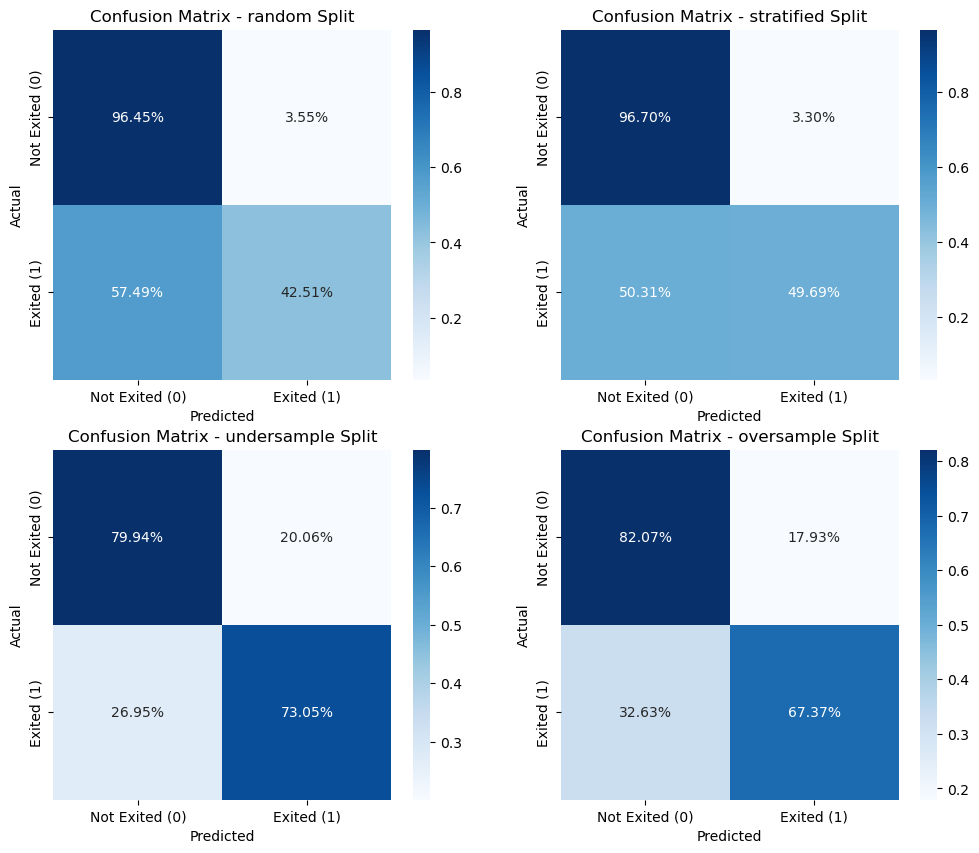

<Figure size 800x600 with 0 Axes>

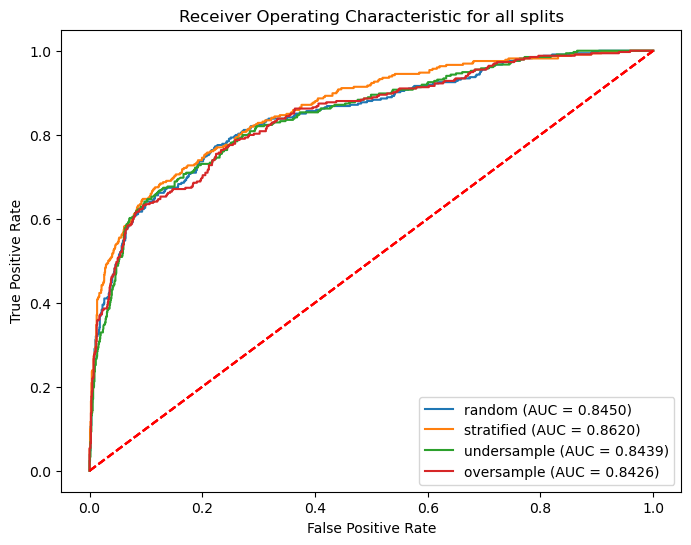

In [112]:
#Creating the model

model = GradientBoostingClassifier(random_state=0)

#Create somewhere to store the performance metrics
performance ={}

def evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance):

    #Creating 2x2 grid for confusion matrices
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    plt.figure(figsize=(8,6))

    #ROC Curve Figure
    plt.figure(figsize=(8,6))

    #Fit model for each of the 4 splits
    for idx, split in enumerate(split_data):

        X_train, X_val, y_train, y_val =split_data[split]
    
        #Train model
        model.fit(X_train, y_train)

        y_score = model.predict_proba(X_val)[:, 1]
    
        #Predict on validation set
        y_val_pred = model.predict(X_val)

        #Plot confusion matrix for test set
        conf_matrix = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = conf_matrix.ravel()

        #Normalize the confusion matrix by the number of true samples per class to get the values of the confusion matrix as a percentage of the total and labelling
        conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[idx],
                    xticklabels=['Not Exited (0)', 'Exited (1)'],
                    yticklabels=['Not Exited (0)', 'Exited (1)'])
        axes[idx].set_title(f'Confusion Matrix - {split} Split')
        axes[idx].set_ylabel('Actual')
        axes[idx].set_xlabel('Predicted')

    
        #Plot ROC curve on the same figure for all splits
        fpr, tpr, _ = roc_curve(y_val, y_score)
        roc_auc = roc_auc_score(y_val, y_score)
        plt.plot(fpr, tpr, label=f'{split} (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for all splits')
        plt.legend(loc="lower right")#

        #Get general classification report
        test_report = classification_report(y_val, y_val_pred, output_dict = True)

        #Balanced accuracy, precision, recall, and F1-score for class 1 (positive class)
        precision = test_report['1']['precision']
        recall = test_report['1']['recall']
        f1_score = test_report['1']['f1-score']
        balanced_acc = balanced_accuracy_score(y_val, y_val_pred)
        
        #Define performance metrics
        performance_matrix[split] = {
            'test_precision_1': precision,
            'test_recall_1': recall,
            'test_f1_score_1': f1_score,
            'false_positives': fp,
            'false_negatives': fn,
            'balanced_accuracy': balanced_acc
        }

    #Show the plots
    plt.show()
    return performance_matrix  

performance = evaluating_performance_diff_splits(model=model,split_data=split_data,performance_matrix=performance)
    

In [113]:
performance_df = pd.DataFrame(performance).T
performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.759358,0.425150,0.545106,45.0,192.0,0.694802
stratified,0.794118,0.496933,0.611321,42.0,164.0,0.731983
undersample,0.489960,0.730539,0.586538,254.0,90.0,0.764954
oversample,0.497788,0.673653,0.572519,227.0,109.0,0.747174


We can see from the ROC curve that the model performs well on all splits, particularly on the oversample and undersample splits. This is to be expected due to the nature of the dataset we're considering as it is imbalanced and the over/undersampling accounts for this.

In the context of our problem, we're interested in getting a high Recall value from our models, since we want to make sure we identify the customers who are going to churn so that the bank can put retention methods in place. 

The effects of the imbalanced dataset can be seen when it comes to the Recall of the random and stratified splits. In both these cases, the make-up of the data in the validation and test sets is expected to be very similar to that of the full dataset. Therefore, when training our model it doesn't have much information to go off when it comes to the predicting those who will churn, since a significantly smaller number of those in our data do churn.

On the contrary, oversampling and undersampling generate balanced test sets and assist model performance leading to the improved performance we can see above. The Recall value in undersampling and oversampling are of a satisfactory level.

In terms of accuracy, the initial Gradient Boosting Classifier model outperforms the baseline on both fronts.

In the following, we'll attempt to refine and improve the model by adjusting the parameters.

## Parameter Tuning

For efficiency reasons, we will use Randomized Search Cross Validation in order to help optimise the parameters of our model. We prefer this to Grid Search Cross Validation as opposed to testing every combination of parameters, it randomly selects them and therefore runs in a fraction of the time.

We'll start by seeing what parameters are currently at play in our model.

In [46]:
#look at the parameters used by our gradient boosting classifier
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

The most important features for us are the learning rate, the number of trees being used, and the depth of these trees. Hence, we'll start with these three parameters and attempt to find the best combination.

For learning rate, values in the neighbourhood of 0.1 will be of most use. A lower learning rate give rise to a more robust model that is less likely to overfit, therefore improving the models performance on unseen data and making it more generalisable.

max_depth is used to control the complexity of each tree that is to be used in this ensemble method. The default value is 3 and a max_depth in and around this value will be useful for us, again to help avoid overfitting and improve the robustness of the model.

When it comes to the number of trees that will be used to generate the final model, or n_estimators, we have a bit more room to play around. Generally, at a high number of trees the model remains robust. 

We now commence the randomised search to find better parameters.

Since the number of trees and the learning rate should be inversely correlated we will begin by investigating just these two features before moving on to the third important feature.

In [114]:
from sklearn.model_selection import RandomizedSearchCV
#We'll use the f1-scorer since we want a low number of false negatives but also want to manage the number of false positives and keep it fairly low.
from sklearn.metrics import make_scorer, f1_score
f1_scorer = make_scorer(f1_score)

param_grid = {
    'n_estimators': [100, 250, 500, 1000, 1250, 1750],
    'learning_rate': [0.005,0.01, 0.05, 0.1, 0.15, 0.2]
}

random_search = RandomizedSearchCV(model, param_grid, n_iter=100, cv=5, scoring=f1_scorer,random_state = 0)
random_search.fit(X_train_raw, y_train_raw)

print(f'Best Parameters: {random_search.best_params_}')


c:\Users\djjjo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'n_estimators': 1750, 'learning_rate': 0.01}


Now that we have values for the supposed 'optimal' values for learning_rate and n_estimators, we will use cross-validation to find what the ideal max_depth is for the model.

In [116]:
param_grid2 = {
    'max_depth': [2,3,4,5,6,7]
}

new_model = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 1750, random_state = 0)

random_search = RandomizedSearchCV(new_model, param_grid2, n_iter=100, cv=5, scoring=f1_scorer,random_state = 0)
random_search.fit(X_train_raw, y_train_raw)

print(f'Best Parameter: {random_search.best_params_}')

c:\Users\djjjo\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameter: {'max_depth': 4}


We will now run a new model with our parameters and generate the same figures and values as before to see if this has improved our model.

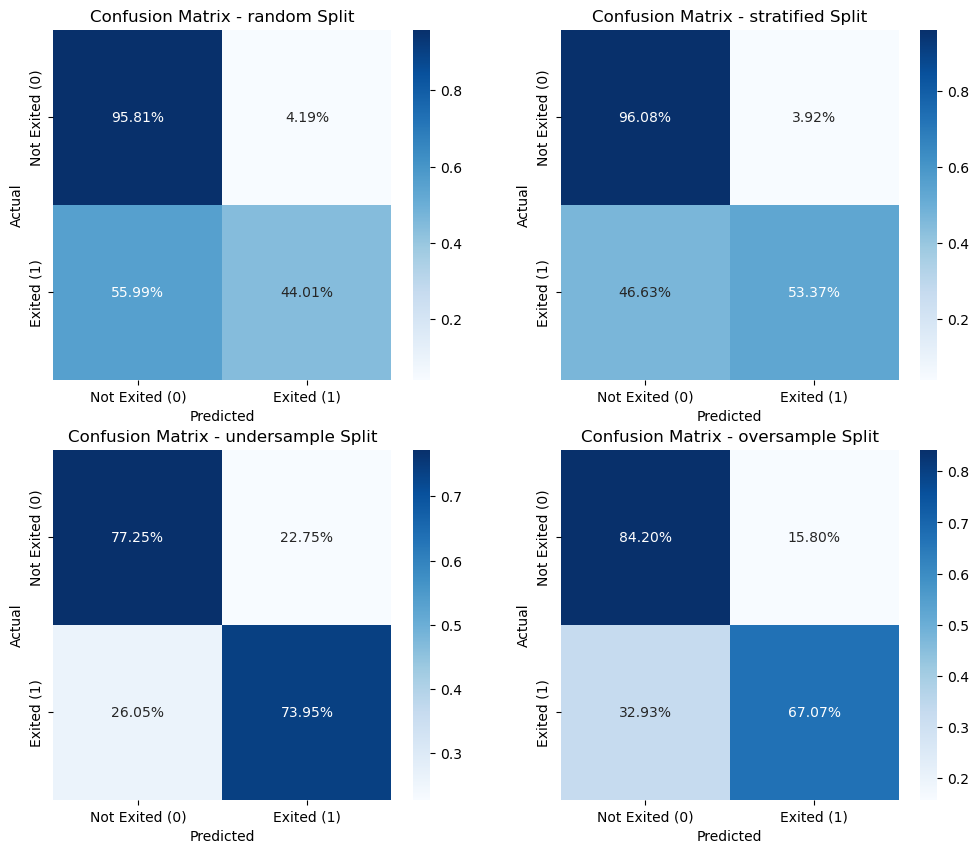

<Figure size 800x600 with 0 Axes>

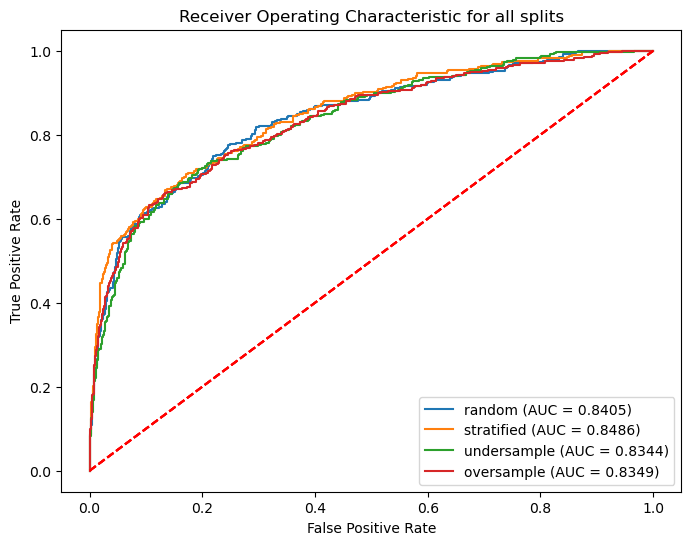

In [120]:
improved_model = GradientBoostingClassifier(n_estimators = 1750, learning_rate = 0.01, max_depth = 4,random_state=0)
performance_improved = {}
performance_improved = evaluating_performance_diff_splits(model=improved_model,split_data=split_data,performance_matrix=performance_improved)


In [121]:
improved_performance_df = pd.DataFrame(performance_improved).T
improved_performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.735000,0.440120,0.550562,53.0,187.0,0.699128
stratified,0.776786,0.533742,0.632727,50.0,152.0,0.747248
undersample,0.461682,0.739521,0.568470,288.0,87.0,0.756016
oversample,0.528302,0.670659,0.591029,200.0,110.0,0.756340


## Comparison to initial model

We'll now take a look at the breakdown of our two different models performance on the test data.

In [122]:
performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.759358,0.425150,0.545106,45.0,192.0,0.694802
stratified,0.794118,0.496933,0.611321,42.0,164.0,0.731983
undersample,0.489960,0.730539,0.586538,254.0,90.0,0.764954
oversample,0.497788,0.673653,0.572519,227.0,109.0,0.747174


In [123]:
improved_performance_df

,test_precision_1,test_recall_1,test_f1_score_1,false_positives,false_negatives,balanced_accuracy
random,0.735000,0.440120,0.550562,53.0,187.0,0.699128
stratified,0.776786,0.533742,0.632727,50.0,152.0,0.747248
undersample,0.461682,0.739521,0.568470,288.0,87.0,0.756016
oversample,0.528302,0.670659,0.591029,200.0,110.0,0.756340


The two performance metrics we're most interested in are the recall and the f1-score due to the context within which our model is being used. 

As we can see above, in terms of recall we can see a healthy improvement on the random and stratified splits, with an increase of 0.015 and 0.037 respectively. 
A slight improvement can be seen in the split in which our model was already performing best, the undersampled split, with the recall value creeping closer to 0.74. 
The recall value associated with the oversampled split has stayed more or less the same, although there is a negligible decrease of 0.003.
On the whole, everything is going in the right direction after the hyperparameter tuning with regards to the recall score across all splits.

Although the recall is our primary focus, we're also interested in the f1-score, as we want to be able to put in measures to retain our customers without wasting resources trying to keep those who will likely stay anyway.
Similarly to the recall score, the f1-score of the random and stratified split, which due to the imbalanced nature of our dataset are our least favourabke splits, has improved slightly, with increases of 0.01 and 0.02 being observed.#
In contrast to the change in recall score for the undersample split, the f1-score for the undersample split has decreased by 0.02, suggesting that the changes we've made to our model for this split is generally predicting more people to churn than previously.
For the oversample split our f1-score has improved by 0.02.
Again, on the whole this is good news and the change in parameters has aided us in creating a more robust and accurate model.

Although we are generally seeing an uptick in the recall and f1-scores across all splits, this isn't the only thing we have to consider when building this model. The methods which we used to arrive at these improved parameters and the nature of these new parameters has proved quite computationally taxing. The general trend in results is a positive one but it might be worth considering if this slight albeit successful process is worth it when we take into account the efficiency and complexity of both the methods used and the new parameters. Since we now have a slower learning rate and a higher number of estimators our model is a lot more robust and more immune to the overfitting that GBCs often suffer from,  however the new, refined model does take a noticeable amount longer to run.

## Feature Removal

One area in which the Gradient Boosting Classifier suffers, similarly to the random forest seen earlier, is overfitting. The removal of certain variables in the data set can help remedy this and decrease the noise in the dataset, leading to improved performance on test sets, a more robust model, and greater generalisability.

We'll begin by seeing what variables are in the dataset.

In [124]:
X_train_rnd, X_val_rnd, y_train_rnd, y_val_rnd = split_data['random']

In [125]:
variables=list(X_train_rnd.columns)
print(variables)

['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'BalanceSalaryRatio', 'TenureByAge', 'CreditScoreGivenAge', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [126]:
new_model.fit(X_train_rnd, y_train_rnd)
importances = new_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': variables, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
1,Age,0.376596
3,NumOfProducts,0.277946
7,IsActiveMember,0.100765
2,Balance,0.060560
4,BalanceSalaryRatio,0.051508
9,Geography_Germany,0.046646
0,CreditScore,0.027726
6,CreditScoreGivenAge,0.027398
5,TenureByAge,0.016577
12,Gender_Male,0.006727


We can see that at a threshold of circa 0.025, gender and geography are important. In the context of our problem and using common sense, although Geography_Germany is above the 0.05 threshold we will remove this feature to remain consistent with removing the other two geographical variables.

In [138]:
importantvars = feature_importance_df.head(7)
print(importantvars)

              Feature  Importance
1                 Age    0.376596
3       NumOfProducts    0.277946
7      IsActiveMember    0.100765
2             Balance    0.060560
4  BalanceSalaryRatio    0.051508
9   Geography_Germany    0.046646
0         CreditScore    0.027726


In [139]:
importantvars_indices = [X_test_raw.columns.get_loc(feature) for feature in importantvars['Feature']]
print(importantvars_indices)

[1, 3, 7, 2, 4, 9, 0]


In [144]:
# Filter the splits to retain only the top 5 features
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    split_data[split] = (
        X_train.iloc[:, importantvars_indices],
        X_val.iloc[:, importantvars_indices],
        y_train,
        y_val
    )

# Verify the changes
for split in split_data:
    X_train, X_val, y_train, y_val = split_data[split]
    print(f"{split} split - X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

IndexError: positional indexers are out-of-bounds

ValueError: Found input variables with inconsistent numbers of samples: [6400, 2594]

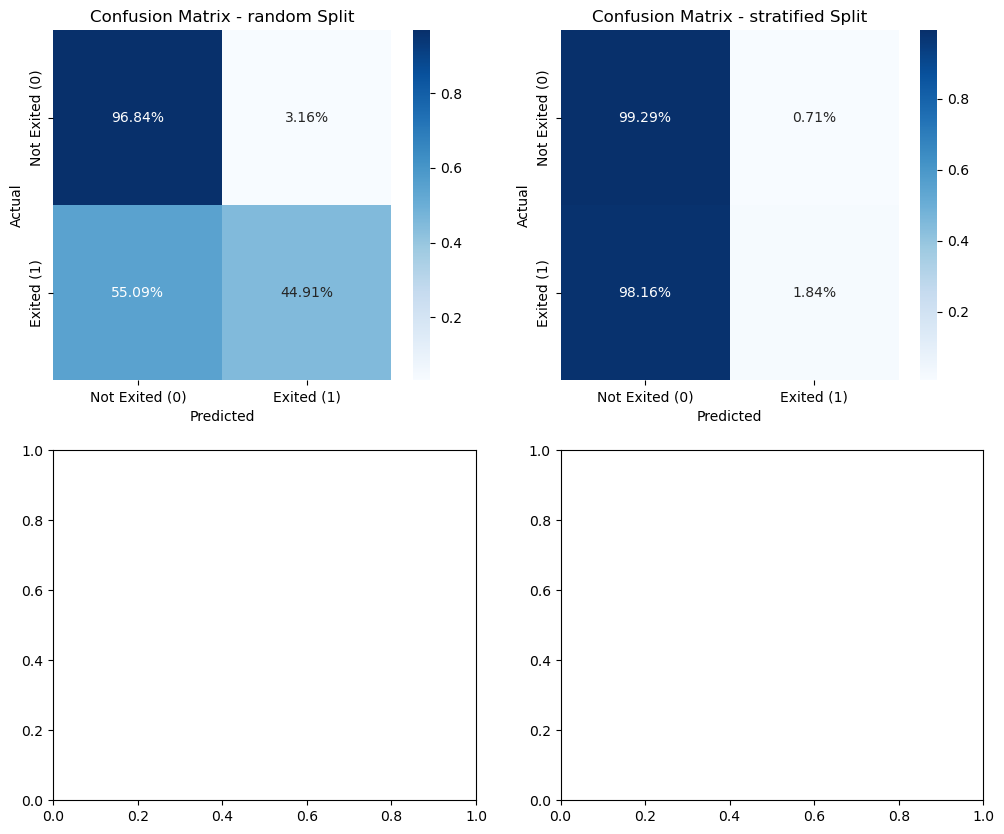

<Figure size 800x600 with 0 Axes>

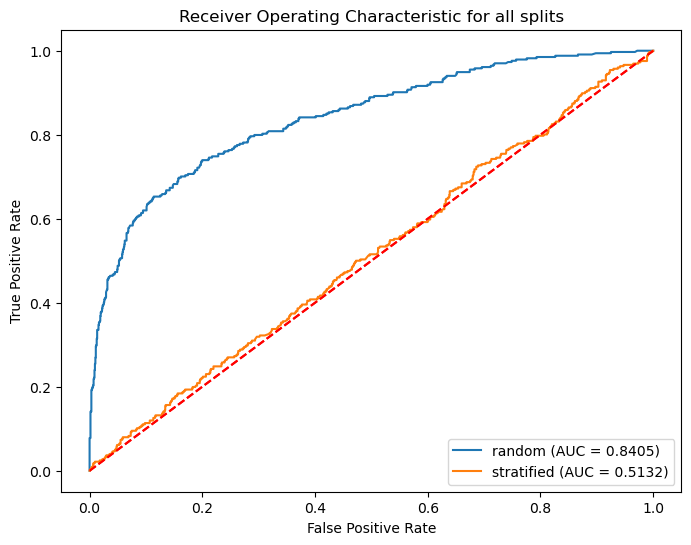

In [143]:
performance_reduced = {}
evaluating_performance_diff_splits(model=new_model,split_data = split_data,performance_matrix=performance_reduced)

performance_reduced_df = pd.DataFrame(performance_reduced).T
performance_reduced_df

## Bagging

We will now combine another ensemble method with our Gradient Boosting Classifier. This is not common practice but it will help improve our model. For this we'll use the model we generated using the hyperparameter tuning.

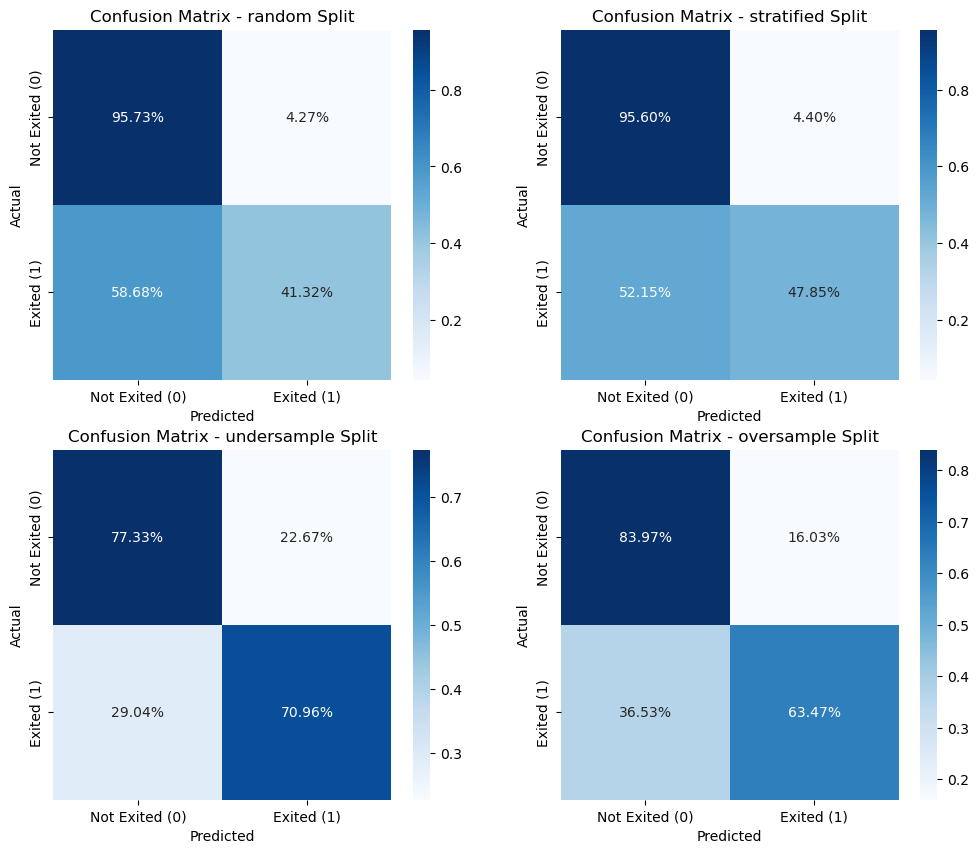

<Figure size 800x600 with 0 Axes>

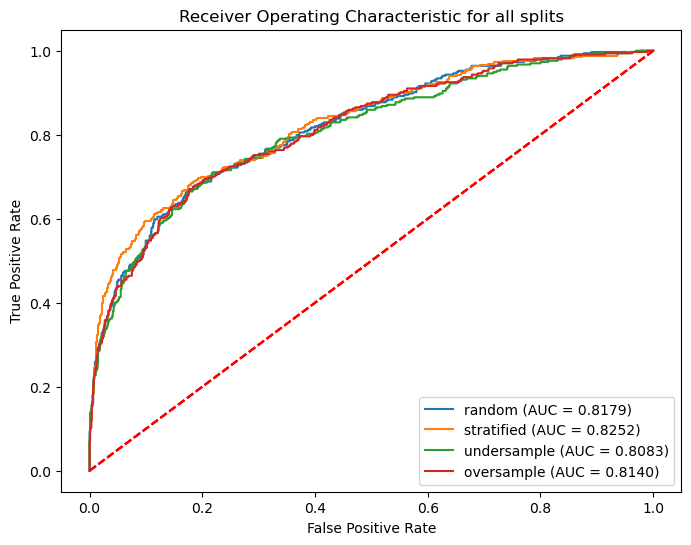

KeyboardInterrupt: 

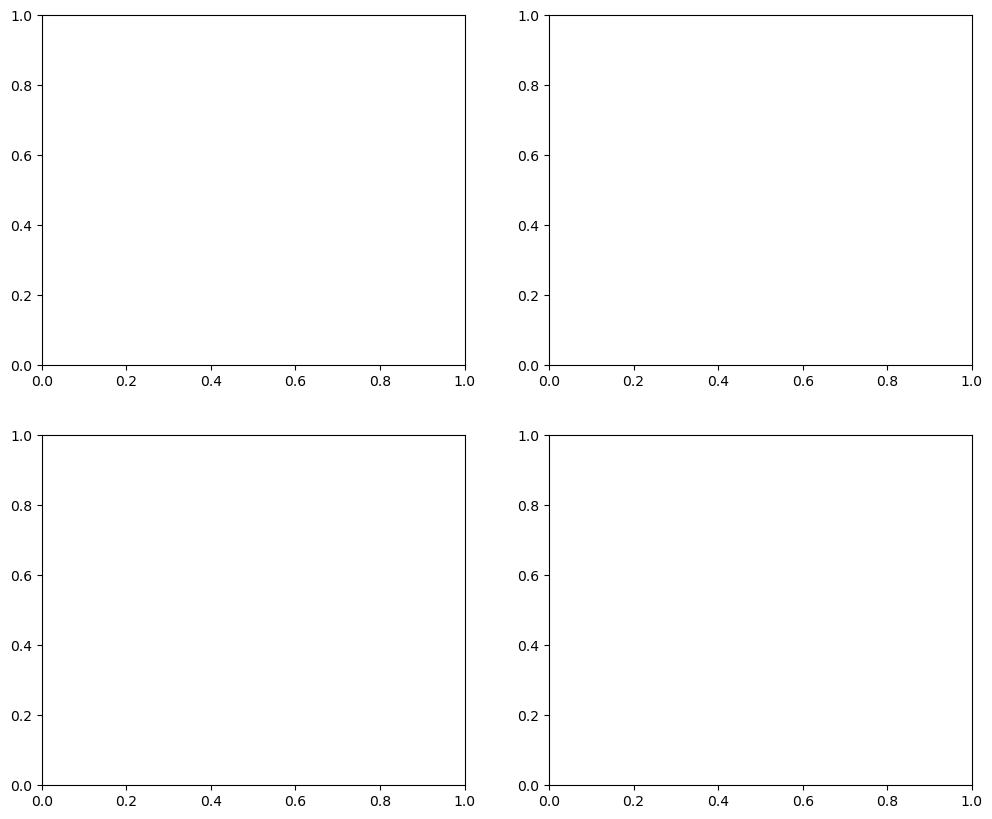

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [107]:
from sklearn.ensemble import BaggingClassifier

estimator_range = [8,12,16,20]

for i in estimator_range:
    bagging_model = BaggingClassifier(estimator=best_model, n_estimators = i, random_state = 0)

    bagging_model.fit(X_train_raw, y_train_raw)

    performance_bagging = {}
    performance_bagging = evaluating_performance_diff_splits(model=bagging_model,split_data=split_data,performance_matrix=performance_bagging)


We can see that with regards to recall value, our model has improved slightly for all splits bar the oversample split, with a peak seen with 12 estimators. But more can still be done to improve our model.